#**Parallel Forecasts for Multiple Units**

We are going to work with Uber pickup data from New York City, from several months in 2014. This data was obtained by 538 as part of a FOIL request to the NY Taxi and Limousine Commission. 

#*Mount Google Drive and Load Uber Data*

In [1]:
import pandas as pd
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Let's read in the CSV file of trips... we will then separate out the date (stripping time). We will make a daily panel of trip volumes. 

In [37]:
!unzip 'drive/My Drive/Teaching/Courses/BA 865/BA865-2023/Lecture Materials/E/datasets/uber_trips.csv.zip'
df = pd.read_csv('uber_trips.csv')
df['date']=pd.to_datetime(df['Date/Time'],format='%m/%d/%Y', infer_datetime_format=True).dt.date
df = df.rename(columns={'Base':'dispatcher'})

Archive:  drive/My Drive/Teaching/Courses/BA 865/BA865-2023/Lecture Materials/E/datasets/uber_trips.csv.zip
replace uber_trips.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: uber_trips.csv          
replace __MACOSX/._uber_trips.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
  inflating: __MACOSX/._uber_trips.csv  


In [38]:
df = df.groupby(['dispatcher','date']).size().reset_index(name='trips')

In [39]:
df.describe(include='all')

,dispatcher,date,trips
count,915,915,915.000000
unique,5,183,NaN
top,B02512,2014-04-01,NaN
freq,183,5,NaN
mean,NaN,NaN,4955.548634
std,NaN,NaN,3806.643828
min,NaN,NaN,114.000000
25%,NaN,NaN,1156.500000
50%,NaN,NaN,5211.000000
75%,NaN,NaN,7723.000000


We now have daily trip volumes associated with 5 dispatchers around New York. I'm not quite sure what a dispatcher represents in this context; perhaps sub-contractors... Now, if we were worried about missing observations in any of the series, we could do the following to identify and populate those values with averages. We are actually fine in this case, however, because there is at least one trip for each dispatcher on each day. 

In [5]:
dispatchers = pd.DataFrame(set(df['dispatcher']), columns=['dispatcher'])
time_index = pd.DataFrame(pd.date_range(start="4/1/2014", end="9/30/2014", freq="D").date,columns=['date'])
skeleton = dispatchers.merge(time_index,how="cross")
skeleton.describe(include='all')

,dispatcher,date
count,915,915
unique,5,183
top,B02682,2014-04-01
freq,183,5


Now we combine our panel skeleton with the observed daily trip data... 

In [6]:
uber_panel = skeleton.merge(df,on=['date','dispatcher'])
uber_panel.describe(include='all')
set(uber_panel['dispatcher'])

{'B02512', 'B02598', 'B02617', 'B02682', 'B02764'}

Now I'm just going to plot the time series of trip volumes in the 5 boroughs. 

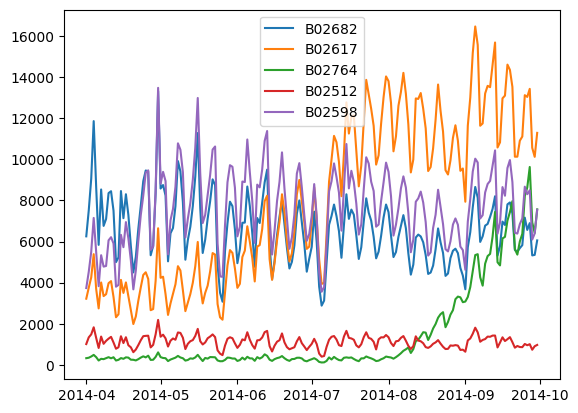

In [7]:
import matplotlib.pyplot as plt

# Let's make one time series for each borough..
for element in set(uber_panel['dispatcher']):
  plt.plot(uber_panel.loc[uber_panel['dispatcher']==element,'date'],uber_panel.loc[uber_panel['dispatcher']==element,'trips'])

plt.legend(list(set(uber_panel['dispatcher'])))

plt.show()

For our forecasting, we need the 5 time series to appear as different features in our data (rather than in sequence). So, let's reshape the dataset.

In [8]:
uber_wide = uber_panel.pivot_table(index=['date'],columns=['dispatcher'],values=['trips'])
uber_wide.reset_index(inplace=True)
uber_wide.columns = uber_wide.columns.droplevel(0)
uber_wide.rename(columns={'':'date'}, inplace=True)
uber_wide.describe()

dispatcher,B02512,B02598,B02617,B02682,B02764
count,183.000000,183.000000,183.000000,183.000000,183.000000
mean,1123.896175,7612.639344,7971.874317,6627.262295,1442.071038
std,285.866727,1869.878997,3956.244438,1591.199878,2185.751429
min,397.000000,3557.000000,1985.000000,2882.000000,114.000000
25%,912.000000,6235.000000,4117.000000,5497.500000,277.000000
50%,1145.000000,7586.000000,7940.000000,6612.000000,356.000000
75%,1337.500000,8903.500000,11574.000000,7652.500000,1428.000000
max,2186.000000,13484.000000,16472.000000,13327.000000,9632.000000


Now, let's make our samples for training, validation, and test.

In [9]:
import math

num_training_obs = math.floor(len(uber_wide)*0.6)
num_validation_obs = math.floor(len(uber_wide)*0.2)
num_test_obs = len(uber_wide)-num_validation_obs-num_training_obs

train_series = uber_wide[:num_training_obs]
validation_series = uber_wide[num_training_obs:num_training_obs+num_validation_obs]
test_series = uber_wide[num_training_obs+num_validation_obs:]

print(num_training_obs)
print(num_validation_obs)
print(num_test_obs)

109
36
38


In [23]:
import numpy as np

n_disps = len(set(uber_panel['dispatcher']))
sequence_len = 14

def make_samples(seq_length,horizon,sample):

  num_obs = sample.shape[0]
  print(num_obs)

  X_data = np.zeros(shape=(num_obs-seq_length-horizon-1,n_disps,seq_length)) # for each dispatcher, make all possible observations, a sequence of daily obs.
  Y_data = np.zeros(shape=(num_obs-seq_length-horizon-1,n_disps,horizon)) # 1 day look-ahead forecast, one for each of 5 dispatchers.
  for i in range(num_obs-seq_length-horizon-1):
      for d in range(n_disps):
          X_data[i,d,:] = sample.iloc[i:i+seq_length,d+1]
          for j in range(horizon):
            Y_data[i,d,j] = sample.iloc[i+seq_length+j,d+1]

  #shuffle_index = np.arange(X_data.shape[0])
  #np.random.shuffle(shuffle_index)
  
  return X_data, Y_data #X_data[shuffle_index], Y_data[shuffle_index]

train_obs, train_labels = make_samples(seq_length=sequence_len, horizon=1, sample = train_series)
val_obs, val_labels = make_samples(seq_length=sequence_len, horizon=1, sample = validation_series)
test_obs, test_labels = make_samples(seq_length=sequence_len, horizon=1, sample = test_series)

109
36
38


In [26]:
print(f'Here is the raw data at the beginning of the training sample for first dispatcher:\n {train_series.iloc[:16,1]}')
print(f'Here are our first couple of training sequences for the first dispatcher:\n {train_obs[0:2,0,:]}.')
print(f'Here are the associated labels for the first dispatcher:\n {train_labels[0:2,0,:]}.')

Here is the raw data at the beginning of the training sample for first dispatcher:
 0     1011
1     1336
2     1482
3     1827
4     1309
5      820
6     1376
7     1023
8     1167
9     1274
10    1362
11    1087
12     783
13     854
14    1391
15    1059
Name: B02512, dtype: int64
Here are our first couple of training sequences for the first dispatcher:
 [[1011. 1336. 1482. 1827. 1309.  820. 1376. 1023. 1167. 1274. 1362. 1087.
   783.  854.]
 [1336. 1482. 1827. 1309.  820. 1376. 1023. 1167. 1274. 1362. 1087.  783.
   854. 1391.]].
Here are the associated labels for the first dispatcher:
 [[1391.]
 [1059.]].


In [27]:
print(train_obs.shape)
print(train_labels.shape)

(93, 5, 14)
(93, 5, 1)


Now we will whiten the predictor (series) values (but not labels), just in case...

In [28]:
train_obs = np.divide(np.subtract(train_obs,np.mean(train_obs)),np.std(train_obs))
val_obs = np.divide(np.subtract(val_obs,np.mean(val_obs)),np.std(val_obs))
test_obs = np.divide(np.subtract(test_obs,np.mean(test_obs)),np.std(test_obs))

#*Let's Setup our Keras Model Now*

We are going to feed in the different units' series as distinct inputs, so each series goes into its own separate LSTM layer. Then we will take the result into a dense layer for our predictions.

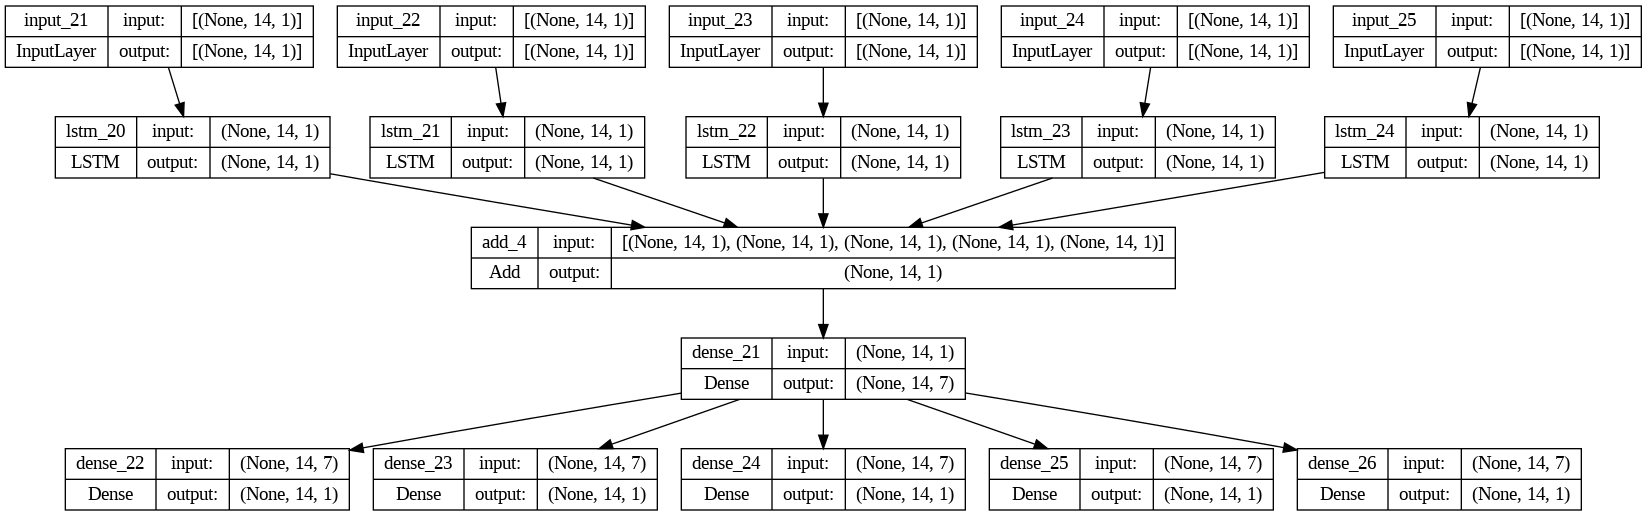

In [32]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

input_0 = layers.Input(shape=(sequence_len,1))
lstm_0 = layers.LSTM(1,return_sequences=True)(input_0)

input_1 = layers.Input(shape=(sequence_len,1))
lstm_1 = layers.LSTM(1,return_sequences=True)(input_1)

input_2 = layers.Input(shape=(sequence_len,1))
lstm_2 = layers.LSTM(1,return_sequences=True)(input_2)

input_3 = layers.Input(shape=(sequence_len,1))
lstm_3 = layers.LSTM(1,return_sequences=True)(input_3)

input_4 = layers.Input(shape=(sequence_len,1))
lstm_4 = layers.LSTM(1,return_sequences=True)(input_4)

merge = layers.Add()([lstm_0,lstm_1,lstm_2,lstm_3,lstm_4])

dense = layers.Dense(units=7, activation="relu")(merge)

output_0 = layers.Dense(1)(dense)
output_1 = layers.Dense(1)(dense)
output_2 = layers.Dense(1)(dense)
output_3 = layers.Dense(1)(dense)
output_4 = layers.Dense(1)(dense)

model_wide = keras.Model(inputs=[input_0,input_1,input_2,input_3,input_4], outputs = [output_0,output_1,output_2,output_3,output_4])

model_wide.compile(optimizer="rmsprop",loss="mae")

keras.utils.plot_model(model_wide, show_shapes=True)

Now we can define our callback, split out the datasets by dispatcher, and then fit the model... you'll notice that, eventually, the loss performance on some of the dispatcher predictions starts to degrade, while others continue to improve. This setup implies joint optimizatoin; your model is optimizing losses across predictions, together. At some point, it will begin to sacrifice the quality of some predictions in favor of others. The question here is whether you might be better off fitting separate models for each series (hint you might be!).

In [41]:
callbacks = [
    keras.callbacks.ModelCheckpoint("drive/My Drive/Teaching/Courses/BA 865/BA865-2023/Lecture Materials/E/uber.keras",
                    save_best_only=True)
]

# Small function to break apart the tensors into a list of datasets, one for each dispatcher's input layer.
def separateData(data):
  separated_data = []
  for i in range(data.shape[1]):
    separated_data.append(data[:,i,:])
  return separated_data

train_obs_list = separateData(train_obs)
train_labels_list = separateData(train_labels)
val_obs_list = separateData(val_obs)
val_labels_list = separateData(val_labels)

# Reload saved model from prior checkpoint... 
# model_wide = keras.models.load_model("drive/My Drive/Teaching/Courses/BA 865/BA865-2023/Lecture Materials/E/uber.keras")

history = model_wide.fit(x=train_obs_list,y=train_labels_list,
                    validation_data=(val_obs_list, val_labels_list),
                    batch_size=1,epochs=250, callbacks = callbacks)

Epoch 1/250
93/93 [==============================] - 2s 16ms/step - loss: 5222.9390 - dense_22_loss: 257.1982 - dense_23_loss: 1684.2660 - dense_24_loss: 1789.4088 - dense_25_loss: 1423.2046 - dense_26_loss: 68.8607 - val_loss: 10063.4082 - val_dense_22_loss: 173.5690 - val_dense_23_loss: 1077.8129 - val_dense_24_loss: 6864.5845 - val_dense_25_loss: 1189.3240 - val_dense_26_loss: 758.1193
Epoch 2/250
93/93 [==============================] - 1s 10ms/step - loss: 5222.6157 - dense_22_loss: 257.1588 - dense_23_loss: 1684.2349 - dense_24_loss: 1789.3004 - dense_25_loss: 1423.1287 - dense_26_loss: 68.7929 - val_loss: 10063.9746 - val_dense_22_loss: 173.5045 - val_dense_23_loss: 1078.7135 - val_dense_24_loss: 6865.4688 - val_dense_25_loss: 1188.8302 - val_dense_26_loss: 757.4579
Epoch 3/250
93/93 [==============================] - 1s 10ms/step - loss: 5222.4976 - dense_22_loss: 257.1385 - dense_23_loss: 1683.9281 - dense_24_loss: 1789.4661 - dense_25_loss: 1423.1112 - dense_26_loss: 68.8535 

This thing is optimizing mean absolute error across all 5 dispatcher forecasts (it's just adding up their losses). If we wanted the model to optimize their forecasts with differing weights, we could use layer_weights in the compile call (upweight those where the variance in trips is higher, for example).

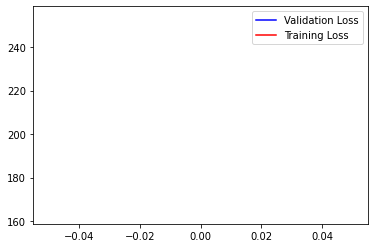

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['val_dense_9_loss'],c="b")
plt.plot(history.history['dense_9_loss'],c="r")
plt.legend(['Validation Loss','Training Loss'])
plt.show()

And now we can see how our model does on the test set... 

1/1 [==============================] - 0s 38ms/step - loss: 15866.3906 - dense_9_loss: 190.1800 - dense_10_loss: 1181.1461 - dense_11_loss: 7754.2173 - dense_12_loss: 740.1387 - dense_13_loss: 6000.7095


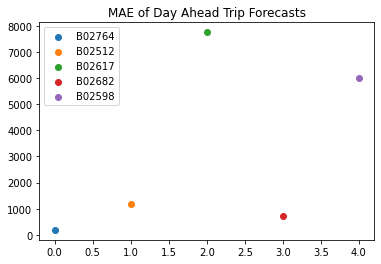

In [ ]:
test_obs_list = separateData(test_obs)
test_labels_list = separateData(test_labels)
mae_results = model_wide.evaluate(test_obs_list,test_labels_list)

plt.scatter(0,mae_results[1])
plt.scatter(1,mae_results[2])
plt.scatter(2,mae_results[3])
plt.scatter(3,mae_results[4])
plt.scatter(4,mae_results[5])
plt.legend(set(uber_panel['dispatcher']))
plt.title('MAE of Day Ahead Trip Forecasts')
plt.show()

#*Single Input Layer that Takes Stacked Series' as 'Features'*

Rather than multi-input, let's try single stacked input...

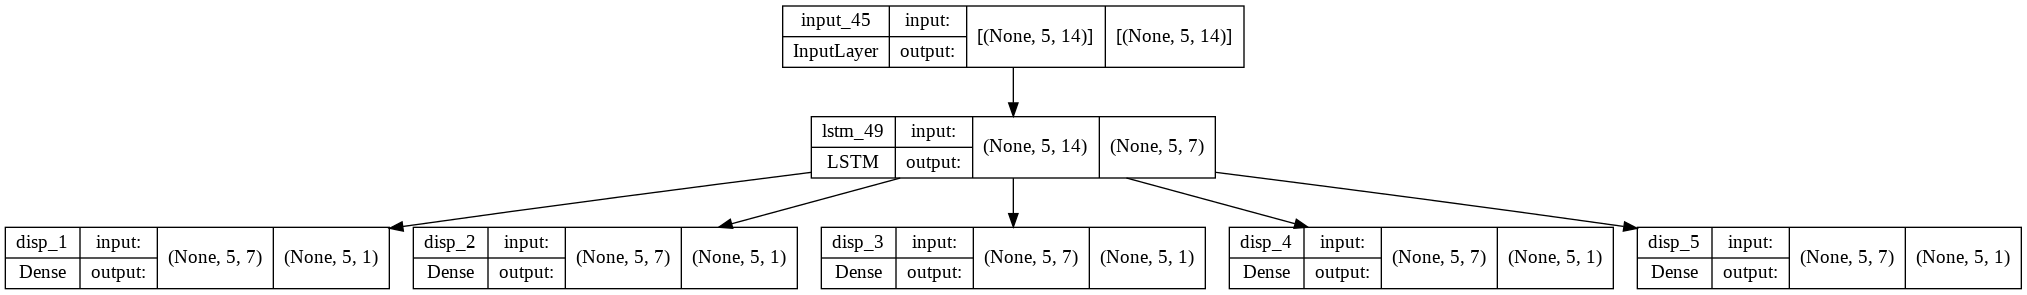

In [ ]:
inputs = keras.Input(shape=(n_disps,sequence_len))
x = layers.LSTM(7,return_sequences=True)(inputs)
x = layers.LSTM(7)(x)
#outputs = layers.Dense(n_disps)(x)

output_0 = layers.Dense(1, name="disp_1")(x)
output_1 = layers.Dense(1, name="disp_2")(x)
output_2 = layers.Dense(1, name="disp_3")(x)
output_3 = layers.Dense(1, name="disp_4")(x)
output_4 = layers.Dense(1, name="disp_5")(x)

model_single = keras.Model(inputs, [output_0,output_1,output_2,output_3,output_4])

model_single.compile(optimizer="rmsprop", loss="mae")

keras.utils.plot_model(model_single, show_shapes=True)

And now we can fit this model... 

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("uber_small.keras",
                                    save_best_only=True)
]
history = model_single.fit(train_obs,train_labels_list,
                    batch_size=1,
                    epochs=1000,
                    validation_data=(val_obs,val_labels_list),
                    callbacks=callbacks)

Epoch 1/1000
93/93 [==============================] - 1s 7ms/step - loss: 18514.4473 - disp_1_loss: 463.7455 - disp_2_loss: 7192.9844 - disp_3_loss: 4662.9854 - disp_4_loss: 6124.3931 - disp_5_loss: 70.3400 - val_loss: 23914.7363 - val_disp_1_loss: 379.1417 - val_disp_2_loss: 6625.6611 - val_disp_3_loss: 11127.6133 - val_disp_4_loss: 5017.6304 - val_disp_5_loss: 764.6857
Epoch 2/1000
93/93 [==============================] - 1s 7ms/step - loss: 18511.8379 - disp_1_loss: 463.2571 - disp_2_loss: 7192.2783 - disp_3_loss: 4662.2793 - disp_4_loss: 6123.6860 - disp_5_loss: 70.3399 - val_loss: 23912.0156 - val_disp_1_loss: 378.5513 - val_disp_2_loss: 6624.9521 - val_disp_3_loss: 11126.9082 - val_disp_4_loss: 5016.9248 - val_disp_5_loss: 764.6767
Epoch 3/1000
93/93 [==============================] - 1s 7ms/step - loss: 18509.2305 - disp_1_loss: 462.7695 - disp_2_loss: 7191.5713 - disp_3_loss: 4661.5713 - disp_4_loss: 6122.9790 - disp_5_loss: 70.3398 - val_loss: 23909.2930 - val_disp_1_loss: 377

And again, let's see how it fares in the test data.

1/1 [==============================] - 1s 782ms/step - loss: 29170.7734 - disp_1_loss: 202.8184 - disp_2_loss: 6646.6890 - disp_3_loss: 11135.4395 - disp_4_loss: 5178.9829 - disp_5_loss: 6006.8433
[29170.7734375, 202.8184051513672, 6646.68896484375, 11135.439453125, 5178.98291015625, 6006.84326171875]


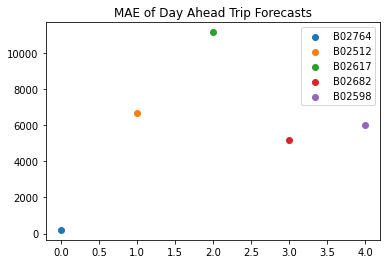

In [ ]:
mae_results_single = model_single.evaluate(test_obs,test_labels_list)

print(mae_results_single)

plt.scatter(0,mae_results_single[1])
plt.scatter(1,mae_results_single[2])
plt.scatter(2,mae_results_single[3])
plt.scatter(3,mae_results_single[4])
plt.scatter(4,mae_results_single[5])
plt.legend(set(uber_panel['dispatcher']))
plt.title('MAE of Day Ahead Trip Forecasts')
plt.show()